<hr size=7 color=#8D84B5 > </hr> 

<div align="center">

# <font color = #6b4cde face="Verdana"> **Universities and Gentrification**
## <font color = #6b4cde face="Verdana"> **UMD CMSC320 Data Science, Spring 2023** </font>
## <font color = #6b4cde face="Verdana"> **Joe Diaz and Connor Pymm** </font>
</center>

</div>

<hr size=7 color=#8D84B5 > </hr> 

### 🙏RUN ME FIRST🙏

In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

<hr size=7 color=#8D84B5 > </hr> 

<div align="center">

## <font color = #6b4cde face="Verdana"> **Data Curation** </font>
</center>

</div>

<hr size=7 color=#8D84B5 > </hr> 

### Selecting Datasets

In order to perform analysis on colleges and their surrounding regions, we needed to
find some subset of colleges, a dataset with characteristics of those colleges on a yearly basis, 
and then a dataset with characteristics of their nearby geographical areas. again yearly. 

Initially, we decided to limit our analysis to the top 100 universities in the country 
according to current US News rankings, under the assumption that more highly ranked universities 
might have a more significant impact on their respective communities. We used Andy Reiter's
“U.S. News & World Report Historical Liberal Arts College and University Rankings” dataset (**citation**).
  
In order to obtain college characteristics, we discovered that the Department of
Education has extensive data available on accredited universities called the College Scorecard, which has
a public API for programatically querying data.
  
In order to obtain characteristics of the region around each university, we needed a dataset that would contain
demographic and economic data for defined geographical regions associated with the location of the University.
We found that the American Community Survey yearly data from the Census had the housing cost and income data we
wanted to analyze, and that its Public Use Microdata API from the census allowed us to programatically request that
data for geographical groupings called "Public Use Microdata Areas," which are the smallest geographical entities that
the Census collects yearly data from.

### Extract, Transform, and Load

Since we queried a *substantial* amount of data from *ridiculously large* datasets,
and requesting federal data from the Department of Education and the Census required
registration for and usage of API keys, we decided that on top of the source datasets that
we were able to download in full, stored in our repository under ETL/source_data, we would
create modules for making federal API requests and loading the results into csv files for usage
later. 
  
Dataframes that we generated from data that we queried were stored under ETL/generated_data
as csv, and then loaded into the notebook when needed, specifically: we built ScorecardData.csv using
our scorecard_client.py module, which defines a CollegeScorecardClient object that can be used to query
DoE data, given a valid API key, set of desired variables, and set of colleges using IPEDS IDs, we built 
college_FIPs by combining the university list we got from Reiter with state FIPs data from DoE and county 
FIPs data by collecting them manually university by university.

For the rest of this tutorial, we will be using the data we collected by default, but if you would like to
recreate the analysis of this tutorial using a different set of colleges, and thus your own datasets, you can
fork this repository and use the modules provided in the ETL/ directory to do so.

<hr size=7 color=#8D84B5 > </hr> 

<div align="center">

## <font color = #6b4cde face="Verdana"> **Data Processing** </font>
</center>

</div>

<hr size=7 color=#8D84B5 > </hr> 

### Loading and Representation

Here, we load the data we have downloaded or generated locally into our
notebook for use to use in our analysis. We stored each of our datasets as
csv, so they are easily loaded into Pandas Dataframes.

In [2]:
# Read dataframes from Scorecard generated data
scard_df = pd.read_csv("ETL/generated_data/ScorecardData.csv")
fips_df = pd.read_csv("ETL/generated_data/college_FIPs.csv")
cpi_df = pd.read_csv("ETL/source_data/cpi_all.csv").groupby("Year")["Value"].mean()
scard_df.head()

student.size  cost.tuition.in_state  cost.tuition.out_of_state  \
0        5042.0                    NaN                        NaN   
1       18337.0                    NaN                        NaN   
2       10395.0                    NaN                        NaN   
3        9203.0                    NaN                        NaN   
4       10120.0                    NaN                        NaN   

   cost.avg_net_price.public  cost.avg_net_price.private      id  \
0                        NaN                         NaN  131159   
1                        NaN                         NaN  100858   
2                        NaN                         NaN  223232   
3                        NaN                         NaN  196079   
4                        NaN                         NaN  164924   

             school.name  school.carnegie_size_setting  school.zip  \
0    American University                            17  20016-8001   
1      Auburn University                            15       36849   
2      Baylor University                            16       76798   
3  Binghamton University                            16  13850-6000   
4         Boston College                            17       02467   

   school.region_id  school.state_fips  school.locale  school.ownership  year  
0                 2                 11             11                 2  1996  
1                 5                  1             13                 1  1996  
2                 6                 48             12                 2  1996  
3                 2                 36             22                 1  1996  
4                 1                 25             13                 2  1996

In [3]:
years = range(2009, 2019)
msa_path_format = "ETL/generated_data/MSA{y}.csv"
MSA_frames = [
    pd.read_csv(msa_path_format.format(y=yr)).assign(year=yr)
    for yr in years
]
pd.read_csv(msa_path_format.format(y=2021)).assign(year=2021)
msa_df = pd.concat(MSA_frames)
msa_df

name  median_household_income  median_monthly_rent  \
0             CO Metro Area"                    59007                 1207   
1             TX Metro Area"                    54146                 1021   
2          NH-VT Micro Area"                    50010                 1034   
3             FL Metro Area"                    45946                 1235   
4             WI Metro Area"                    52024                  985   
..                       ...                      ...                  ...   
18            MA Metro Area"                    57857                 1089   
19            CA Metro Area"                    84395                 1755   
20   DC-VA-MD-WV Metro Area"                   102180                 1812   
21         VA-NC Metro Area"                    65604                 1256   
22            CA Metro Area"                    72563                 1700   

        msa  year  
0    19740]  2009  
1    26420]  2009  
2    30100]  2009  
3    33100]  2009  
4    33340]  2009  
..      ...   ...  
18   44140]  2018  
19   46700]  2018  
20   47900]  2018  
21   47260]  2018  
22  31080]]  2018  

[230 rows x 5 columns]

In [4]:
years = range(2009, 2019)
puma_path_format = "ETL/generated_data/PUMA{y}.csv"
PUMA_frames = [
    pd.read_csv(puma_path_format.format(y=yr)).assign(year=yr)
    for yr in years
]
pd.read_csv(puma_path_format.format(y=2021)).assign(year=2021)
puma_df = pd.concat(PUMA_frames)
puma_df

median_household_income  median_monthly_rent  state_id  puma  year
0                     52023                 1060         6  1800  2009
1                     69677                 1710         6  2001  2009
2                     49350                 1244         6  2101  2009
3                     89826                 1608         6  2702  2009
4                     86209                 1643         6  2703  2009
..                      ...                  ...       ...   ...   ...
71                    70646                 1328        48  2001  2018
72                    77794                 1218        48  2101  2018
73                    55923                 1207        48  4603  2018
74                   101788                 1736        48  4604  2018
75                    49895                  724        55   100  2018

[766 rows x 5 columns]

### Data Cleaning and Reshaping

The data that we have still uses the variable names and formatting of our
original sources, and those variable names are unweildy and not ideal for usage
in analysis later, so we rename our columns to be more human readable and
developer friendly. Additionally, cost data in our sources does not account for
inflation, so we should use an all-consumers/all-goods CPI to transform our dollar
values to a standard value.

In [5]:
# Rename columns to be more readable, usable
scard_df = scard_df.rename(
    columns={
        "student.size": "size",
        "cost.tuition.in_state": "in_state_tuition",
        "cost.tuition.out_of_state": "out_state_tuition",
        "cost.avg_net_price.public": "public_net_price",
        "cost.avg_net_price.private": "private_net_price",
        "id": "ipeds_id",
        "school.name": "name",
        "school.carnegie_size_setting": "size_setting",
        "school.zip": "zip",
        "school.state_fips": "state_fips",
        "school.region_id": "region_id",
        "school.locale": "locale",
        "school.ownership": "ownership"
    }
)

# Join county FIPs codes into College Scorecard dataframe for use later in
# associating with Census geographies.
scard_df = pd.merge(scard_df, fips_df[["name", "county", "cbsa", "puma"]], on="name", how="left").drop_duplicates()


# Combine public and private net prices into a single net price column, and drop those columns
scard_df["net_cost"] = scard_df.apply(lambda row: 
            row["public_net_price"] if (row["ownership"] == 1) else row["private_net_price"],
        axis=1
)
scard_df["net_cost_adjusted"] = scard_df.apply(lambda row: 
            (row["net_cost"]/cpi_df.at[row["year"]]) * 100,
        axis=1
)
scard_df["in_tuition_adjusted"] = scard_df.apply(lambda row: 
            (row["in_state_tuition"]/cpi_df.at[row["year"]]) * 100,
        axis=1
)
scard_df["out_tuition_adjusted"] = scard_df.apply(lambda row: 
            (row["out_state_tuition"]/cpi_df.at[row["year"]]) * 100,
        axis=1
)
scard_df.drop(["public_net_price", "private_net_price"], axis=1, inplace=True)
scard_df.head()

size  in_state_tuition  out_state_tuition  ipeds_id  \
0   5042.0               NaN                NaN    131159   
1  18337.0               NaN                NaN    100858   
2  18337.0               NaN                NaN    100858   
3  10395.0               NaN                NaN    223232   
4   9203.0               NaN                NaN    196079   

                    name  size_setting         zip  region_id  state_fips  \
0    American University            17  20016-8001          2          11   
1      Auburn University            15       36849          5           1   
2      Auburn University            15       36849          5           1   
3      Baylor University            16       76798          6          48   
4  Binghamton University            16  13850-6000          2          36   

   locale  ownership  year  county     cbsa    puma  net_cost  \
0      11          2  1996     1.0  47900.0   101.0       NaN   
1      13          1  1996    81.0  12220.0  2101.0       NaN   
2      13          1  1996    81.0  10760.0  2101.0       NaN   
3      12          2  1996   309.0  47380.0  3801.0       NaN   
4      22          1  1996     7.0  13780.0  2201.0       NaN   

   net_cost_adjusted  in_tuition_adjusted  out_tuition_adjusted  
0                NaN                  NaN                   NaN  
1                NaN                  NaN                   NaN  
2                NaN                  NaN                   NaN  
3                NaN                  NaN                   NaN  
4                NaN                  NaN                   NaN

We can note that some rows do not have cost data associated with them, thus they are missing data.
Since we will use this cost data later in our analysis, we need to either interpolate the missing data
or drop the invalid rows. Here, we experiment with dropping rows with missing data.

In [6]:
scard_clipped = scard_df.dropna(subset=["net_cost", "in_state_tuition", "out_state_tuition"]).copy()
#print(scard_clipped["name"].unique().shape)
#print(scard_clipped.to_string())

(103,)
         size  in_state_tuition  out_state_tuition  ipeds_id                                                 name  size_setting         zip  region_id  state_fips  locale  ownership  year  county     cbsa     puma  net_cost  net_cost_adjusted  in_tuition_adjusted  out_tuition_adjusted
1989   6430.0           34973.0            34973.0    131159                                  American University            17  20016-8001          2          11      11          2  2009     1.0  47900.0    101.0   40345.0       18803.189093         16299.514987          16299.514987
1990  19918.0            6972.0            19452.0    100858                                    Auburn University            15       36849          5           1      13          1  2009    81.0  12220.0   2101.0   13225.0        6163.642973          3249.370042           9065.798345
1991  19918.0            6972.0            19452.0    100858                                    Auburn University            15       3

It seems as if the clipped dataframe after dropping null cost data is just the data after 2009.
To verify that this is true, I try querying the original dataset purely by restricting the years.
If there is complete cost data from 2009 to 2020, then the resulting dataframe should be equal to the
dataframe resulting from dropping null data. Run the next code cell to confirm this.

In [7]:
scard_clipped_year = scard_df[scard_df["year"] >= 2009].copy()
scard_clipped_year.equals(scard_clipped)

True

In [8]:
msa_df["msa"] = msa_df["msa"].str.replace("]", "").astype(int)
msa_df

/tmp/ipykernel_9448/1876715125.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  msa_df["msa"] = msa_df["msa"].str.replace("]", "").astype(int)


name  median_household_income  median_monthly_rent  \
0             CO Metro Area"                    59007                 1207   
1             TX Metro Area"                    54146                 1021   
2          NH-VT Micro Area"                    50010                 1034   
3             FL Metro Area"                    45946                 1235   
4             WI Metro Area"                    52024                  985   
..                       ...                      ...                  ...   
18            MA Metro Area"                    57857                 1089   
19            CA Metro Area"                    84395                 1755   
20   DC-VA-MD-WV Metro Area"                   102180                 1812   
21         VA-NC Metro Area"                    65604                 1256   
22            CA Metro Area"                    72563                 1700   

      msa  year  
0   19740  2009  
1   26420  2009  
2   30100  2009  
3   33100  2009  
4   33340  2009  
..    ...   ...  
18  44140  2018  
19  46700  2018  
20  47900  2018  
21  47260  2018  
22  31080  2018  

[230 rows x 5 columns]

In [9]:
scard_clipped_geo = scard_clipped.dropna(subset=["cbsa", "puma"]).copy()
scard_clipped_geo

size  in_state_tuition  out_state_tuition  ipeds_id  \
1989   6430.0           34973.0            34973.0    131159   
1990  19918.0            6972.0            19452.0    100858   
1991  19918.0            6972.0            19452.0    100858   
1992  12101.0           28070.0            28070.0    223232   
1993  11635.0            6761.0            14661.0    196079   
...       ...               ...                ...       ...   
3820   7366.0           57386.0            57386.0    179867   
3821   6217.0           23628.0            46854.0    231624   
3822   4804.0           54416.0            54416.0    168421   
3823   4701.0           57700.0            57700.0    130794   
3824   2619.0           46475.0            46475.0    197708   

                                   name  size_setting         zip  region_id  \
1989                American University            17  20016-8001          2   
1990                  Auburn University            15       36849          5   
1991                  Auburn University            15       36849          5   
1992                  Baylor University            16       76798          6   
1993              Binghamton University            16  13850-6000          2   
...                                 ...           ...         ...        ...   
3820  Washington University in St Louis            17  63130-4899          4   
3821                     William & Mary            14  23187-8795          5   
3822    Worcester Polytechnic Institute            13  01609-2280          1   
3823                    Yale University            17       06520          1   
3824                 Yeshiva University            14  10033-3299          2   

      state_fips  locale  ownership  year  county     cbsa     puma  net_cost  \
1989          11      11          2  2009     1.0  47900.0    101.0   40345.0   
1990           1      13          1  2009    81.0  12220.0   2101.0   13225.0   
1991           1      13          1  2009    81.0  10760.0   2101.0   13225.0   
1992          48      12          2  2009   309.0  47380.0   3801.0   24174.0   
1993          36      22          1  2009     7.0  13780.0   2201.0   13999.0   
...          ...     ...        ...   ...     ...      ...      ...       ...   
3820          29      21          2  2020   510.0  41180.0   2001.0   26921.0   
3821          51      23          1  2020   830.0  47260.0   9500.0   19593.0   
3822          25      12          2  2020    27.0  49340.0    505.0   42835.0   
3823           9      12          2  2020     9.0  35300.0  20601.0   15296.0   
3824          36      11          2  2020    61.0  35620.0   4112.0   39536.0   

      net_cost_adjusted  in_tuition_adjusted  out_tuition_adjusted  
1989       18803.189093         16299.514987          16299.514987  
1990        6163.642973          3249.370042           9065.798345  
1991        6163.642973          3249.370042           9065.798345  
1992       11266.533477         13082.303082          13082.303082  
1993        6524.373382          3151.031391           6832.905076  
...                 ...                  ...                   ...  
3820       10400.208357         22169.546331          22169.546331  
3821        7569.231542          9128.045877          18100.789806  
3822       16548.156642         21022.166263          21022.166263  
3823        5909.200514         22290.851833          22290.851833  
3824       15273.676223         17954.373292          17954.373292  

[1656 rows x 19 columns]

In [10]:
full_uni_list = scard_df["name"].unique().tolist()
mapped_uni_list = fips_df["name"].unique().tolist()
clipped_uni_list = scard_clipped_geo["name"].unique().tolist()

cul_set = set(clipped_uni_list)
uni_diff1 = [uni for uni in full_uni_list if uni not in cul_set]
uni_diff2 = [uni for uni in mapped_uni_list if uni not in cul_set]

print(len (uni_diff1))
print(len (uni_diff2))

print (uni_diff1)

15
0
['Brown University', 'Emory University', 'Gonzaga University', 'Michigan State University', 'North Carolina State University at Raleigh', 'Ohio State University-Main Campus', 'Southern Methodist University', 'Stony Brook University', 'Texas A & M University-College Station', 'Texas Christian University', 'University of California-Riverside', 'University of California-Santa Barbara', 'University of North Carolina at Chapel Hill', 'University of Rochester', 'University of Washington-Seattle Campus']


<hr size=7 color=#8D84B5 > </hr> 

<div align="center">

## <font color = #6b4cde face="Verdana"> **Exploratory Analysis and Data Visualization** </font>
</center>

</div>

<hr size=7 color=#8D84B5 > </hr> 

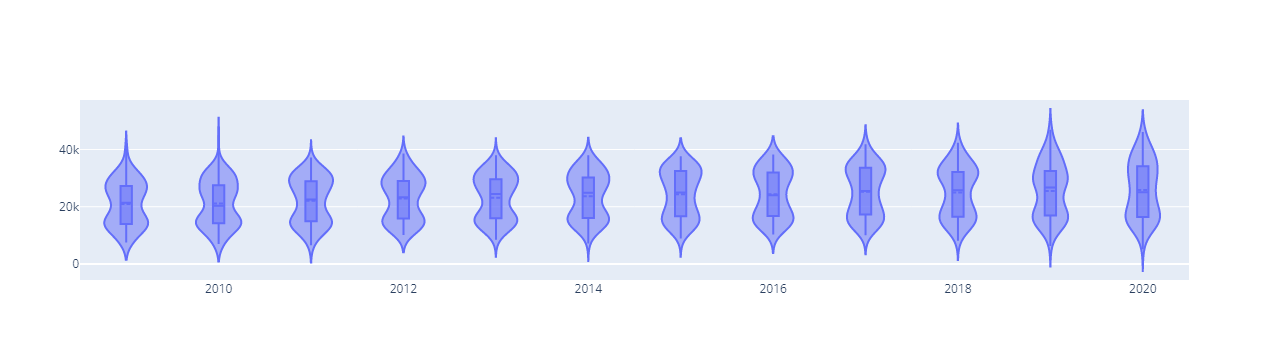

In [11]:
fig = go.Figure()
fig.add_trace(
    go.Violin(
        x=scard_clipped['year'], 
        y=scard_clipped['net_cost'],
        box_visible=True,
        meanline_visible=True
    )
)
fig.show()

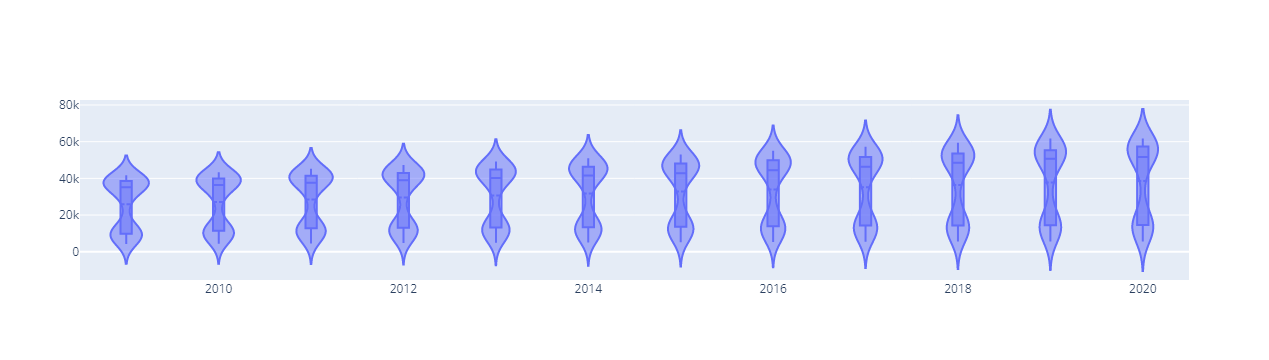

In [12]:
fig = go.Figure()
fig.add_trace(
    go.Violin(
        x=msa_df['year'], 
        y=msa_df['msa'],
        box_visible=True,
        meanline_visible=True
    )
)
fig.show()

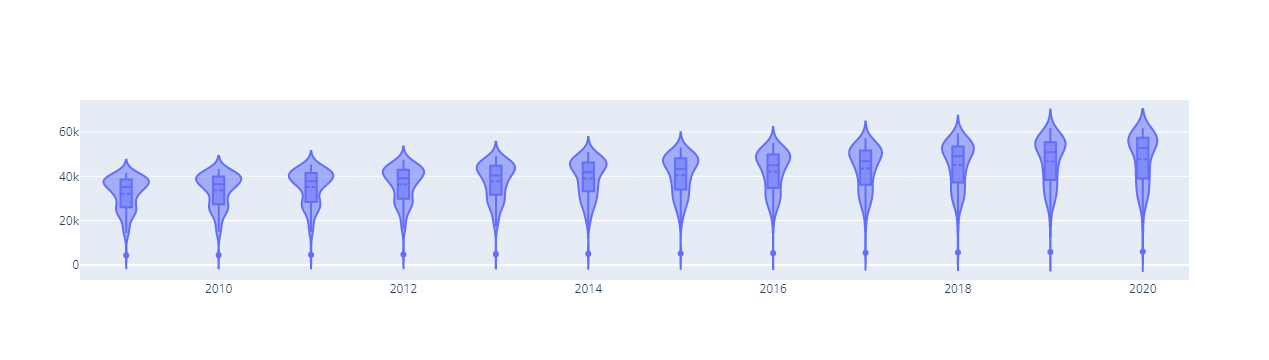

In [13]:
fig = go.Figure()
fig.add_trace(
    go.Violin(
        x=scard_clipped['year'], 
        y=scard_clipped['out_state_tuition'],
        box_visible=True,
        meanline_visible=True
    )
)
fig.show()

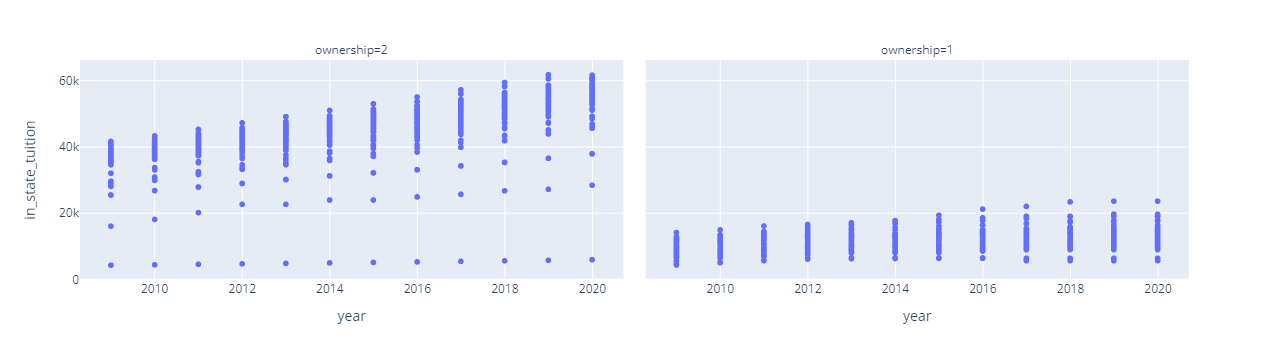

In [14]:
fig = px.scatter(scard_clipped, x="year", y="in_state_tuition", facet_col="ownership")
fig.show()


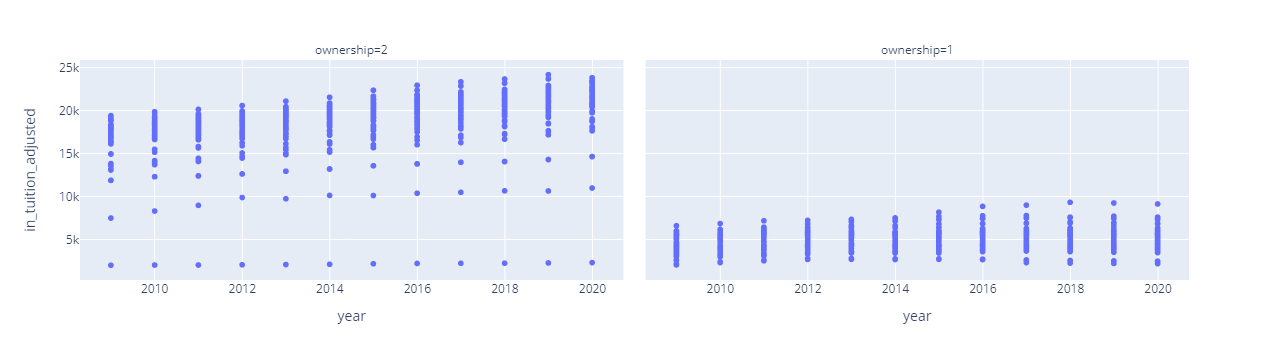

In [15]:
fig = px.scatter(scard_clipped, x="year", y="in_tuition_adjusted", facet_col="ownership")
fig.show()

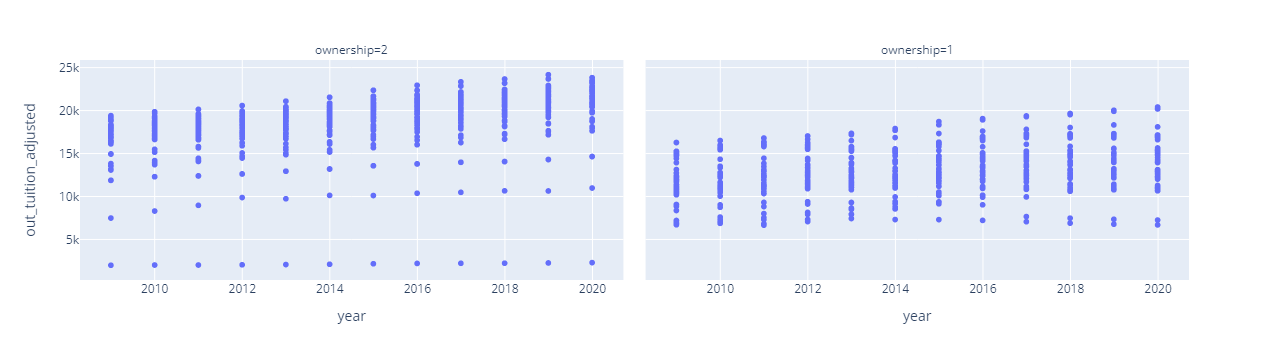

In [16]:
fig = px.scatter(scard_clipped, x="year", y="out_tuition_adjusted", facet_col="ownership")
fig.show()

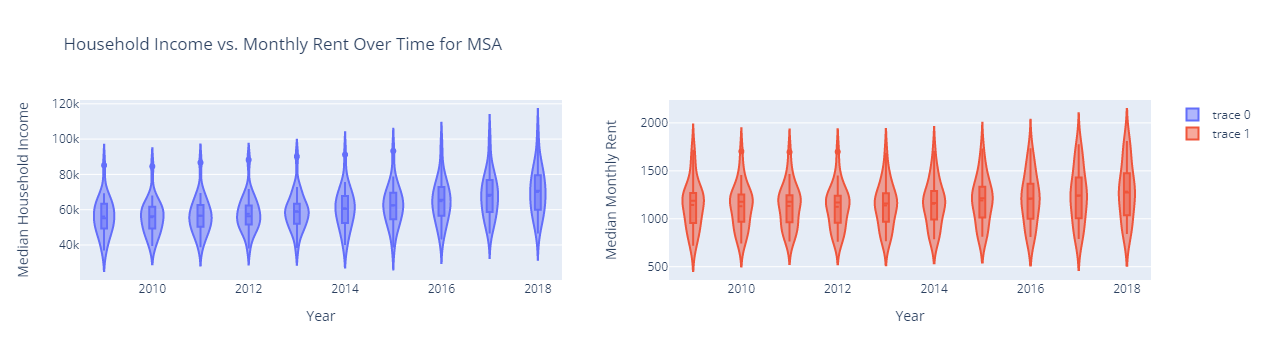

In [31]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Violin(x=msa_df["year"], 
              y=msa_df["median_household_income"], 
              box_visible=True,
              meanline_visible=True
             ),
    row=1, col=1
)
fig.add_trace(
    go.Violin(x=msa_df["year"], 
              y=msa_df["median_monthly_rent"], 
              box_visible=True,
              meanline_visible=True
             ),
    row=1, col=2
)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Median Household Income", row=1, col=1)
fig.update_yaxes(title_text="Median Monthly Rent", row=1, col=2)
fig.update_layout(title_text="Household Income vs. Monthly Rent Over Time for MSA")
fig.show()

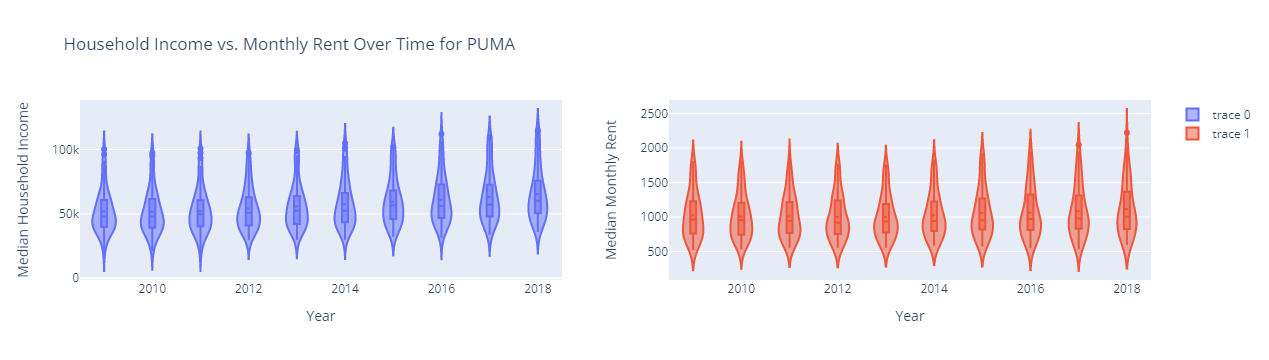

In [30]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Violin(x=puma_df["year"], 
              y=puma_df["median_household_income"], 
              box_visible=True,
              meanline_visible=True
             ),
    row=1, col=1
)
fig.add_trace(
    go.Violin(x=puma_df["year"], 
              y=puma_df["median_monthly_rent"], 
              box_visible=True,
              meanline_visible=True
             ),
    row=1, col=2
)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Median Household Income", row=1, col=1)
fig.update_yaxes(title_text="Median Monthly Rent", row=1, col=2)
fig.update_layout(title_text="Household Income vs. Monthly Rent Over Time for PUMA")
fig.show()

Interesting observation that household income is lower on average for PUMA vs. MSA, but rent peaks at a higher value for PUMA compared to MSA.

<hr size=7 color=#8D84B5 > </hr> 

<div align="center">

## <font color = #6b4cde face="Verdana"> **Analysis, Hypothesis Testing, and Machine Learning** </font>
</center>

</div>

<hr size=7 color=#8D84B5 > </hr> 